# Vehicle Detection and Tracking
---
> Daniel Stang
    

## Extract Features From Image

### Histogram of Gradient

In [308]:
# Import
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from moviepy.editor import VideoFileClip
from moviepy.editor import CompositeVideoClip

print('Import successful.')

Import successful.


In [309]:
# Histogram of Oriented Gradients
def hog_features(img, cspace='gry', chan=0, orientbin=9, cellpix=8, cellb=2, visual=False, vector=True):
    
    # Pick feature and channel to perform HOG on.
    if cspace == 'rgb':
        newimg = img[:,:,chan]
    if cspace == 'gry':
        newimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if cspace == 'hsv':
        tmpimg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        newimg = tmpimg[:,:,chan]
    if cspace == 'luv':
        tmpimg =  cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        newimg = tmpimg[:,:,chan]
    if cspace == 'hls':
        tmpimg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        newimg = tmpimg[:,:,chan]
    if cspace == 'yuv':
        tmpimg = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        newimg = tmpimg[:,:,chan]    
    
    if visual == True:
        features, visual_image = hog(newimg, orientations=orientbin,
                                     pixels_per_cell=(cellpix, cellpix),
                                     cells_per_block=(cellb, cellb),
                                     transform_sqrt=True,
                                     visualise=True, feature_vector=True)
        return features, visual_image
    else:
        features = hog(newimg, orientations=orientbin,
                       pixels_per_cell=(cellpix, cellpix),
                       cells_per_block=(cellb, cellb),
                       transform_sqrt=True,
                       visualise=False, feature_vector=True)
        return features
        
    

In [310]:
def color_hist(img, nbins=32, bins_range=(0,1)):
    # Calculate the histogram for each color channel.
    chan1hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    chan2hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    chan3hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms in one feature.
    histfeat = np.concatenate((chan1hist[0], chan2hist[0], chan3hist[0]))
    return histfeat/1000


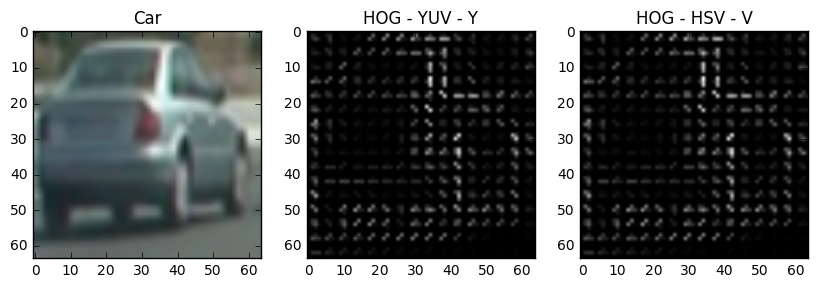

In [311]:
img = mpimg.imread('img/vehicles/GTI_Left/image0010.png')
#img = mpimg.imread('img/non-vehicles/GTI/image1.png')



orientbin = 12
cellpix = 4
cellb = 1

features, visual_image = hog_features(img, 'yuv', 0, orientbin, cellpix, cellb, True)
colorh = color_hist(img)
features2 = np.append(features, hog_features(img, 'hsv', 2))


features, visual_image2 = hog_features(img, 'hsv', 2, orientbin, cellpix, cellb, True)

fig = plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(img)
plt.title('Car')
plt.subplot(132)
plt.imshow(visual_image, cmap='gray')
plt.title('HOG - YUV - Y')
plt.subplot(133)
plt.imshow(visual_image2, cmap='gray')
plt.title('HOG - HSV - V')
plt.show()

# fig = plt.figure(figsize=(10,5))
# plt.plot(features2)
# plt.show()

x_scaler = StandardScaler().fit(features2)
scaledx = x_scaler.transform(features2)

# fig = plt.figure(figsize=(10,5))
# plt.plot(scaledx)
# plt.show()



## Train Classifier

The first classifier I made was a linear SVC using the one channel from each of the HSV and YUV channels. Max accuracy I could get was .967 % which when scanning over 100+ sliding windows still produces a great deal of false positives each frame.

### Label Data


In [312]:
imagename = sorted(glob.glob('img/non-vehicles/Extras/*.png'))
imagename2 = sorted(glob.glob('img/non-vehicles/GTI/*.png'))
imagename = imagename + imagename2
notcarlen = len(imagename)
print(notcarlen)
foldername = sorted(glob.glob('img/vehicles/*'))
for fold in foldername:
    imagename2 = sorted(glob.glob(fold + '/*.png'))
    imagename = imagename + imagename2

print(imagename[notcarlen-1])
print(imagename[notcarlen])
print(len(imagename))


9666
img/non-vehicles/GTI/image999.png
img/vehicles/GTI_Far/image0000.png
18458


In [313]:
# Load all images and extract features.
img = mpimg.imread('img/vehicles/GTI_Left/image0010.png')
feat1 = hog_features(img, 'yuv', 0)
feat2 = np.append(feat1, hog_features(img, 'hsv', 2))
testfeat = np.append(feat2, hog_features(img, 'hls', 1))

xdata = np.zeros((18458,len(feat2))).astype('float32')
i=0
for imgn in tqdm(imagename):
    imgd = mpimg.imread(imgn)
    feat1 = hog_features(imgd, 'yuv', 0)
    feat2 = np.append(feat1, hog_features(imgd, 'hsv', 2))
    xdata[i] = feat2
    i = i + 1

    

100%|██████████| 18458/18458 [00:38<00:00, 483.53it/s]


In [314]:
# Ensure that non vehicles labeled with 0 and vehicles labeled with 1.
y = np.zeros(18458).astype(int)
y[9666:] = 1

print(str(imagename[9665]) + ' ' + str(y[9665]))
print(str(imagename[9666]) + ' ' + str(y[9666]))
print(str(imagename[1337]) + ' ' + str(y[1337]))
print(str(imagename[13337]) + ' ' + str(y[13337]))

img/non-vehicles/GTI/image999.png 0
img/vehicles/GTI_Far/image0000.png 1
img/non-vehicles/Extras/extra2201.png 0
img/vehicles/KITTI_extracted/1760.png 1


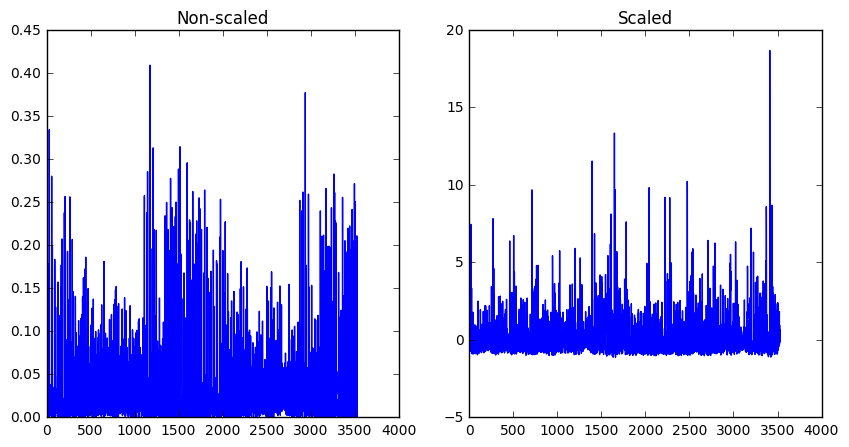

14766
14766
3692
3692


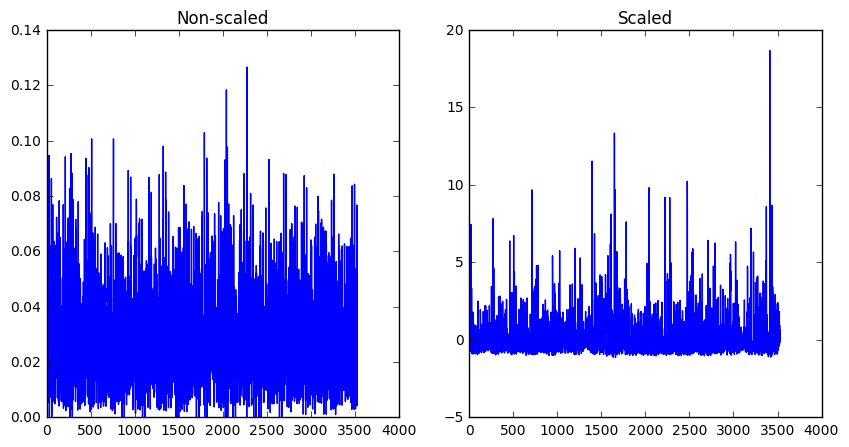

In [315]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(xdata[15000])
plt.title('Non-scaled')

X_scaler = StandardScaler().fit(xdata)
scaledx = X_scaler.transform(xdata)

plt.subplot(122)
plt.plot(scaledx[0])
plt.title('Scaled')
plt.show()

x_train, x_test, y_train, y_test = train_test_split(xdata, y, test_size=0.2, random_state=1337)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(xdata[2])
plt.title('Non-scaled')

scaledx2 = X_scaler.transform(xdata[0])

plt.subplot(122)
plt.plot(scaledx2)
plt.title('Scaled')
plt.show()

### SVC

In [316]:
linsvc = svm.LinearSVC(loss='squared_hinge',tol=1e-4, max_iter=1000)
t = time.time()
linsvc.fit(x_train, y_train)
t2 = time.time()

print('Training time:', t2-t, 'seconds')
print('Train Accuracy', linsvc.score(x_train, y_train))
print('Test Accuracy', linsvc.score(x_test, y_test))


# Test Accuracy 0.966955579632 non-scaled.
# Test Accuracy 0.95747 scaled accuracy.

Training time: 9.08475637435913 seconds
Train Accuracy 0.988622511174
Test Accuracy 0.966955579632


    Just HOG
    HLS [0, .933], [1, .959], [2, .905]
    HSV [0, .933], [1, .910], [2, .954]
    YUV [0, .963], [1, .947], [2, .xxx]
    RGB [0, .950], [1, .960], [2, .956]
    
    With Color Hist
    YUV [0, 0.954]
    
    hsv2 + yuv0 - nonscaled - 0.967
                - scaled - 0.955
    hsv2 + yuv + hls1 - nonscaled - 0.967
                      - scaled - 0.957
                      
Scaling train accuracy jumps but test accuracy doesn't.

In [317]:
a = linsvc.predict(x_test)
b = linsvc.decision_function(x_test)
print(a)
print(b)

decision_num = 0.4
b[b >= decision_num] = 1
b[b < decision_num] = 0
print(b)
print(accuracy_score(y_test, b))

[0 0 1 ..., 1 0 0]
[-1.47433539 -1.84156679  2.35107701 ...,  4.43163621 -1.30945096
 -2.67138989]
[ 0.  0.  1. ...,  1.  0.  0.]
0.962621885157


In [318]:
# svc = svm.SVC(kernel='linear')
# t = time.time()
# svc.fit(x_train, y_train)
# t2 = time.time()

# print('Training time:', t2-t, 'seconds')
# print('Train Accuracy', svc.score(x_train, y_train))
# print('Test Accuracy', svc.score(x_test, y_test))


# Stats using rbf kernel.
# 1.9 seconds to fit 922 samples.
# 121 seconds to fit 9229 samples.
# Takes waaaay to long when using rbf on so many samples
# and linear SVC seems to do just fine accuracy wise.

### Decision Tree

In [319]:
dtree = tree.DecisionTreeClassifier(min_samples_split=20, max_depth=8)
t = time.time()
dtree = dtree.fit(x_train, y_train)
t2 = time.time()

print('Training time:', t2-t, 'seconds')
print('Train Accuracy', dtree.score(x_train, y_train))
print('Test Accuracy', dtree.score(x_test, y_test))
    

Training time: 35.40605020523071 seconds
Train Accuracy 0.953541920628
Test Accuracy 0.879739978332


## Sliding Window Search


In [320]:
def debug_img():
    img = mpimg.imread('CarND-Vehicle-Detection/test_images/test6.jpg')
    windows = slide_window(img,0.5)
    imgbox = draw_boxes(img, windows)
    print(len(windows))
        
    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(imgbox)
    plt.title('Overlap')

    windows = slide_window(img, 0)
    imgbox = draw_boxes(img, windows)
    print(len(windows))
    plt.subplot(122)
    plt.imshow(imgbox)
    plt.title('No Overlap')
    plt.tight_layout()
    plt.show()

    img = mpimg.imread('CarND-Vehicle-Detection/test_images/test3.jpg')
    windows = slide_window(img,0)
    imgbox = draw_boxes(img, windows)
    print(len(windows))
    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(imgbox)
    plt.title('Car')

    windows = slide_window(img, 0.75)
    imgbox = draw_boxes(img, windows)
    print(len(windows))
    plt.subplot(122)
    plt.imshow(imgbox)
    plt.title('Window')
    plt.tight_layout()
    plt.show()


822
732


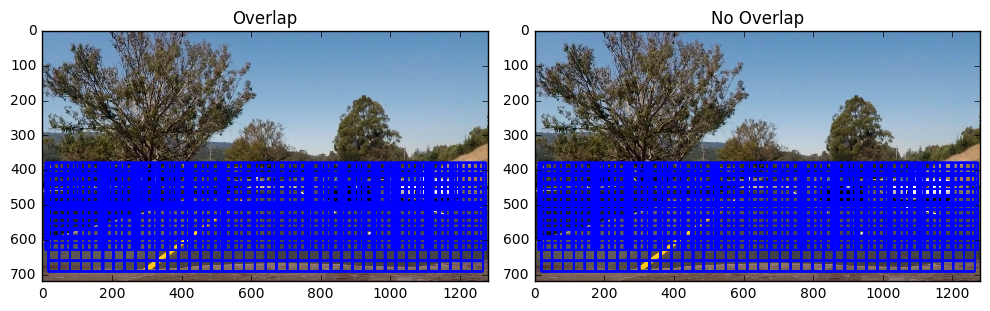

732
1218


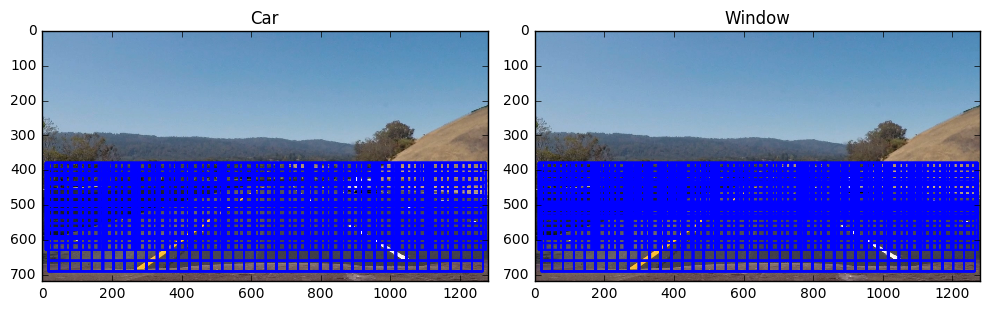

In [321]:
# Draw boxes on new image. Input bboxes is a list of tuples.
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

# Crop window area of image 
def crop_resize(img, window):
    
    crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    
    resize = cv2.resize(crop, (64, 64))
    
    return resize

# Return x and y coordinates for all computed window search positions.
def slide_window(img, xy_overlap = 0.5, xy_window = 64, y_start_stop=[380, None]):
    
    
    xcenter = np.int(img.shape[1]/2)
    
    # If y start/stop positions not defined, set to image size.    
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Initialize a list to append window positions to.
    window_list = []

    
    starty = y_start_stop[0]
    ny_window = 3
    growth = 1.104
    
    for yi in range(0,ny_window):
        step = np.int(xy_window *(1 - xy_overlap))
        endy = starty + xy_window
        nx_window = np.int(img.shape[1]/(step*2))
        if yi == 0:
            nx_window = nx_window - 1*np.int(xy_window/step)
            # How many xy_window tall pixels should be covered in the y direction.
            ystack = 2
            xy_overlap = 0.8
        if yi == 1:
            nx_window = nx_window - 0*np.int(xy_window/step)
            ystack = 2
            # Used for largest window, not current (yi == 2).
            xy_overlap = 0.8
        if yi == 2:
            nx_window = nx_window - 0*np.int(xy_window/step)
            ystack = 2
        
        # Ensures that both overlap and non-overlap cases cover the same number of pixels
        # in the y direction. Ex smallest boxes want to cover 2 * 64 pixels. With non-overlap
        # thats two sets of 64 pixel tall windows stacked on top of eachother. For 50% overlap 
        # that requires 3 sets of 64 pixels tall windows with 50% overlap.
        if xy_overlap != 0:
            ystack =  np.int(ystack*(xy_window/step)) - 1
            
        for yii in range(ystack):
            for xi in range(nx_window):
                startx = xcenter + xi*step
                endx = startx + xy_window
                # Only add to list if within image bounds.
                if endx < img.shape[1]:
                    if startx > 0:
                        if endy < img.shape[0]:
                            window_list.append( ((startx, starty), (endx, endy)) )

                endx = xcenter - xi*step
                startx = endx - xy_window
                # Only add to list if within image bounds.
                if startx > 0:
                    if endx < img.shape[1]:
                        if endy < img.shape[0]:
                            window_list.append( ((startx, starty), (endx, endy)) )
            
            starty = starty + step
            endy = starty + xy_window
            
        starty = y_start_stop[0]
        xy_window = np.int(xy_window **growth)
        
        
    
    # Return the list of window positions.
    return window_list

debug_img()

((1056, 428), (1120, 492))
[[1056  428 1120  492]
 [1134  380 1232  478]
 [ 830  399  928  497]
 [ 849  399  947  497]
 [1115  399 1213  497]
 [1134  399 1232  497]
 [ 849  418  947  516]
 [ 795  411  952  568]]


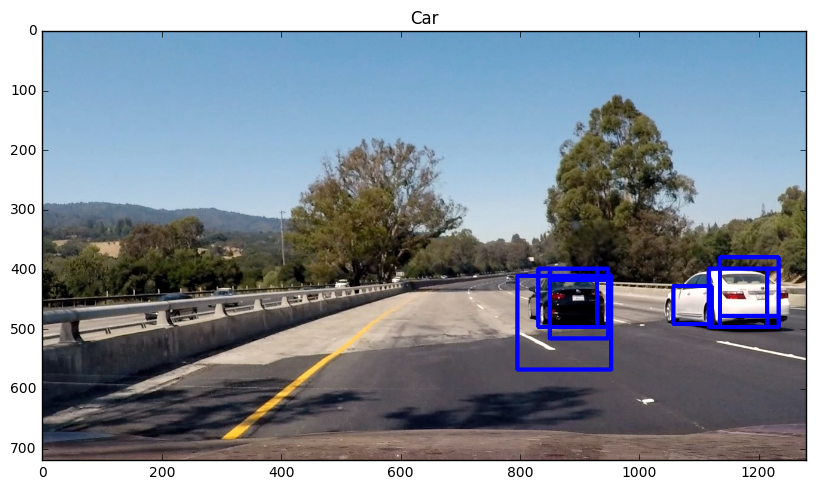

In [322]:
locationimage = 'CarND-Vehicle-Detection/test_images/test4.jpg'
img = mpimg.imread(locationimage)
img2 = mpimg.imread(locationimage)
windows = slide_window(img,0.75)

b = None
for i in range(len(windows)):
    newimg = crop_resize(img, windows[i])
    #a = linsvc.predict(hog_features(newimg, 'yuv', 0).reshape(1, -1))
    feat = np.append(hog_features(newimg, 'yuv', 0), hog_features(newimg, 'hsv', 2))
    featscaled = X_scaler.transform(feat)
    #feat2 = np.append(feat, hog_features(newimg, 'hls', 1))
    #c = x_scaler.transform(d)
    #a = linsvc.predict(feat.reshape(1,-1))
    a = linsvc.decision_function(feat.reshape(1,-1))
    if a >= .7:
        if b == None:
            b = np.hstack(windows[i])
            print(windows[i])
            #b = temp
            img2 = draw_boxes(img2, windows[i:i+1])
        else:
            temp = np.hstack(windows[i])
            img2 = draw_boxes(img2, windows[i:i+1])
            b = np.vstack((b, temp)).astype(int)

print(b)
fig = plt.figure(figsize=(10,5))
plt.imshow(img2)
plt.title('Car')
plt.tight_layout()
plt.show()


Scaling vs non-scaling observations.

Settings 0.6 cut off. All written in terms of scaling.

    test1 - Picks up way more windows on both cars. Picks up two pieces of noise that aren't in non-scaled.
    test2 - Picks up 5 windows where as non-scaled picked up 1.
    test3 - Picks up 2 on car (vs 1 on non-scaled) but also picks up 3 more noise windows (2 close together).
    test4 - Picks up considerable more windows on both cars but also on window of noise more.
    test5 - Picks up more windows on cars but also picks up horrible amounts of noise in shadow and trees.
    test6 - Picks up more windows on cars but also two windows of noise.

For test5, cut off of 1.5 atleast is needed for noise to be at acceptable levels. 

### Combining Multiple Prediction Boxes

[[1056  428 1120  492]
 [1134  380 1232  478]
 [ 830  399  928  497]
 [ 849  399  947  497]
 [1115  399 1213  497]
 [1134  399 1232  497]
 [ 849  418  947  516]
 [ 795  411  952  568]]
[(1056, 380, 1232, 497), (795, 399, 952, 568)]


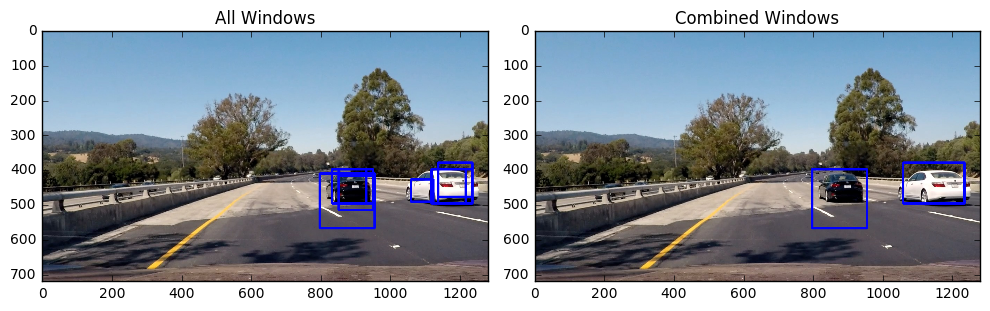

In [323]:
def draw_pred_boxes(img, box, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    cv2.rectangle(imcopy, (box[0], box[1]), (box[2], box[3]), color, thick)
    return imcopy

def combine_pred(img, pred_windows):
    # Find overlaping or touching windows and group them.
    
    # If no prediction windows return original image.
    if pred_windows == None:
        return img, []
    
    # If only one prediction window return image with one low confidence box.
    if pred_windows.size == 4:
        #img = draw_pred_boxes(img, pred_windows, (255,0,255))
        return img, []
    
    prednum = np.zeros( (len(pred_windows),len(pred_windows)) )
    
    # Calculate centroids of each window.
    cent = []
    for window in pred_windows:
        xcent = np.int((window[0] + window[2])/2)
        ycent = np.int((window[1] + window[3])/2)
        
        cent.append((xcent, ycent))
    
    # Classify windows as a group if distance to another centroid is within set number
    # of pixels in x or y direction.
    for i in range(len(cent)):
        group = i+1
        
        # If this window already has an existing match
        # set its group number to that number.
        temppred = prednum[:,i]
        if len(temppred[temppred > 0]) > 0:
            group = temppred[temppred >0][0]
            
        for j in range(len(cent)):
            if i == j:
                continue
                
            # Compare x distance.
            if (abs(cent[i][0] - cent[j][0]) <= 100): # was 110
                # Compare y distance.
                if (abs(cent[i][1] - cent[j][1]) <= 64):
                    # If a match is found, check if the match is already assigned
                    # a group number.
                    temppred = prednum[:,j]
                    if len(temppred[temppred > 0]) > 0:
                        group = temppred[temppred > 0][0]
                    
                    # Assign the group number to that location.
                    # i represents the window being compared and j represents
                    # the window that is found to match.
                    prednum[i,j] = group
                    
    
    # Represent grouping of windows in 1D array.
    predgroup = np.zeros(len(cent))
    for i in range(len(cent)):
        predgroup[i] = max(prednum[i,:])
    
    #print('predgroup:',predgroup)
    
    
    # Draw pink boxes around all low confidence (single window prediction) detections.
#     singleloc = np.where(predgroup == 0)
#     if len(singleloc[0]) > 0:
#         for i in range(len(singleloc[0])):
#             img = draw_pred_boxes(img, pred_windows[singleloc[0][i]], (255,0,255))
    
    # Set group window to largest rectangle containing all the windows that group.
    groupwindoutput = []
    for i in range(1, len(cent)+1):
        grouploc = np.where(predgroup == i)
        grouplen = len(grouploc[0])
        if grouplen > 1:
            groupwind = np.array([img.shape[1], img.shape[0], 0, 0])
            for j in range(grouplen):
                windloc = grouploc[0][j]
                # Replace group window location with windows to create largest 
                # encasing rectangle.
                if pred_windows[windloc][0] < groupwind[0]:
                    groupwind[0] = pred_windows[windloc][0]
                if pred_windows[windloc][1] < groupwind[1]:
                    groupwind[1] = pred_windows[windloc][1]
                if pred_windows[windloc][2] > groupwind[2]:
                    groupwind[2] = pred_windows[windloc][2]
                if pred_windows[windloc][3] > groupwind[3]:
                    groupwind[3] = pred_windows[windloc][3]
            
            # Draw box containing all prediction windows.
            if grouplen > 3:
                img = draw_pred_boxes(img, groupwind)
                groupwindoutput.append( ((groupwind[0], groupwind[1], groupwind[2], groupwind[3])) )
            #else:
                #img = draw_pred_boxes(img, groupwind, (255,0,255))
            #groupwindoutput.append( ((groupwind[0], groupwind[1], groupwind[2], groupwind[3])) )
    #return predgroup
    return img, groupwindoutput

print(b)
imgpred, groupwind = combine_pred(img,b)
print(groupwind)
imagebox = draw_pred_boxes(img, groupwind[1])

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img2)
plt.title('All Windows')

windows = slide_window(img, 0.75)
imgbox = draw_boxes(img, windows)
plt.subplot(122)
plt.imshow(imgpred)
plt.title('Combined Windows')
plt.tight_layout()
plt.show()


# fig = plt.figure(figsize=(10,5))
# plt.imshow(imgpred)
# plt.title('Car')
# plt.tight_layout()
# plt.show()

## Video Pipeline

Now that I have a method to predict car locations in a still image it is time to try out it on a video stream.

> Track data from one frame to the next. Performing focused window search on place where in previous frame a car was detected.

32
[((1122, 393), (1167, 438)), ((1144, 393), (1189, 438)), ((1099, 393), (1144, 438)), ((1144, 415), (1189, 460)), ((1099, 415), (1144, 460)), ((1144, 437), (1189, 482)), ((1099, 437), (1144, 482)), ((1111, 372), (1177, 438)), ((1144, 372), (1210, 438)), ((1078, 372), (1144, 438)), ((1144, 405), (1210, 471)), ((1078, 405), (1144, 471)), ((1144, 438), (1210, 504)), ((1078, 438), (1144, 504)), ((1093, 387), (1195, 489)), ((1062, 355), (1227, 520)), ((851, 438), (896, 483)), ((873, 438), (918, 483)), ((828, 438), (873, 483)), ((873, 460), (918, 505)), ((828, 460), (873, 505)), ((873, 482), (918, 527)), ((828, 482), (873, 527)), ((840, 417), (906, 483)), ((873, 417), (939, 483)), ((807, 417), (873, 483)), ((873, 450), (939, 516)), ((807, 450), (873, 516)), ((873, 483), (939, 549)), ((807, 483), (873, 549)), ((822, 432), (924, 534)), ((791, 400), (956, 565))]


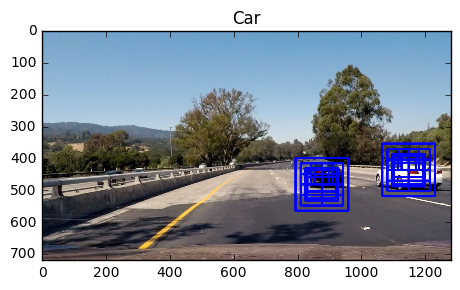

In [324]:
# Need another function that when a car might have been detected, another focused sliding window search
# is performed on that specific area to have a better chance at detection.
# Return x and y coordinates for all computed window search positions.
def slide_window_focus(img, center, xy_overlap = 0.5):
    xcenter = center[0]
    
    # If y start/stop positions not defined, set to image size.    
    xy_window = 32
    
    # Initialize a list to append window positions to.
    window_list = []
    ny_window = 5
    growth = 1.104
    
    for yi in range(0,ny_window):
        step = np.int(xy_window *(1 - xy_overlap))
        
        # Individual settings for each size of window.
        if yi == 0:
            nx_window = 0
            ystack = 0#3
        if yi == 1:
            nx_window = 1
            ystack = 2#2
        if yi == 2:
            nx_window = 1#3
            ystack = 2#2
        if yi == 3:
            nx_window = 1#2
            ystack = 0#2
        if yi == 4:
            nx_window = 1
            ystack = 0

        # Ensures that y distance is consistent with and without overlap.
        if xy_overlap != 0:
            ystack =  np.int(ystack*(xy_window/step)) - 1
        
               
        if ystack > 0:
            starty = np.int(center[1] - (xy_window))
        else:
            starty = np.int(center[1] - xy_window/2) 
        endy = starty + xy_window
        
        # If only one window is meant to be created, window centered around
        # x and y centers. 
        if nx_window == 1:
            startx = xcenter - np.int(xy_window/2)
            endx = startx + xy_window
            if startx > 0:
                if endx < img.shape[1]:
                    if starty > 0:
                        if endy < img.shape[0]:
                            window_list.append( ((startx, starty), (endx, endy)) )
            
        
        for yii in range(ystack):
            for xi in range(nx_window):
                startx = xcenter + xi*step
                endx = startx + xy_window
                # Only add to list if within image bounds.
                if endx < img.shape[1]:
                    if startx > 0:
                        if starty > 0:
                            if endy < img.shape[0]:
                                window_list.append( ((startx, starty), (endx, endy)) )

                endx = xcenter - xi*step
                startx = endx - xy_window
                # Only add to list if within image bounds.
                if startx > 0:
                    if endx < img.shape[1]:
                        if starty > 0:
                            if endy < img.shape[0]:
                                window_list.append( ((startx, starty), (endx, endy)) )
            
            starty = starty + step
            endy = starty + xy_window
            
        
        xy_window = np.int(xy_window **growth)
        
        
    
    # Return the list of window positions.
    return window_list

windows = []
for wind in groupwind:
    xcenter = np.int((wind[0] + wind[2])/2)
    ycenter = np.int((wind[1] + wind[3])/2)
    windows.extend(slide_window_focus(img, [xcenter, ycenter]))
img = mpimg.imread('CarND-Vehicle-Detection/test_images/test4.jpg')

print(len(windows))
print(windows)
imgbox = draw_boxes(img, windows)

fig = plt.figure(figsize=(6,3))
plt.imshow(imgbox)
plt.title('Car')

plt.tight_layout()
plt.show()

In [307]:
locationimage = 'CarND-Vehicle-Detection/test_images/test5.jpg'
img = mpimg.imread(locationimage)

class Car():
    def __init__(self):
        self.loc = []
        self.allwind = []
        self.count = -1
        
Cars = Car()
font = cv2.FONT_HERSHEY_SIMPLEX
def process_image(image):
    
    Cars.count = Cars.count + 1
    if ((Cars.count % 12) != 0):
#         if (Cars.allwind == None):
#             return image
#         if (Cars.allwind.size < 5): # If only one window is found, ignore this frame.
#             return image
        
#         for i in Cars.allwind:
#             image = draw_pred_boxes(image, i)
        for groups in Cars.loc:
            image = draw_pred_boxes(image, groups)
        return image
    

    # Use previous frame information about car detection to add more detection windows
    # in area where car was detected to increase chances of detecting it in this frame.
    windgroup = []
    for wind in Cars.loc:
        xcenter = np.int((wind[0] + wind[2])/2)
        ycenter = np.int((wind[1] + wind[3])/2)
        windgroup.extend(slide_window_focus(img, [xcenter, ycenter]))
#         image = draw_boxes(image,windgroup)
    
    windows = slide_window(image,0.75)
    windows.extend(windgroup)
    
    
    pred_windows = None
    
    # This first iteration is done outside of loop so that the correct size of featdata
    # can be initialized.
    cropimg = crop_resize(image, windows[0])
    feat = np.append(hog_features(cropimg, 'yuv', 0), hog_features(cropimg, 'hsv', 2))
    featdata = np.zeros((len(windows),len(feat))).astype('float32')
    featdata[0] = feat
    
    # Loop and gather all features data for each cropped window.
    for i in range(1,len(windows)):
        cropimg = crop_resize(image, windows[i])
        #feat = np.append(hog_features(cropimg, 'yuv', 0), hog_features(cropimg, 'hsv', 2))
        featdata[i] = np.append(hog_features(cropimg, 'yuv', 0), hog_features(cropimg, 'hsv', 2))
    
    # Run classifier on all of the feature data.
    featscaled = X_scaler.transform(featdata)
    croppred = linsvc.decision_function(featdata)
    for i in range(len(windows)):
        # Decision function is used with a cut off 0.3 to filter out predictions that 
        # the SVC isn't confident about.
        if croppred[i] >= .5:
            if pred_windows == None:
                pred_windows = np.hstack(windows[i])
                #image = draw_boxes(image, windows[i:i+1])
            else:
                temp = np.hstack(windows[i])
                pred_windows = np.vstack((pred_windows, temp)).astype(int)
                #image = draw_boxes(image, windows[i:i+1])
    
    
    imgpred, groupwind = combine_pred(image,pred_windows)
    Cars.loc = groupwind
    Cars.allwind = pred_windows
    return imgpred


vid_output = 'allwind07notscaled-lap3-dist100-64.mp4'
clip1 = VideoFileClip("CarND-Vehicle-Detection/project_video.mp4")
vid_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video allwind07notscaled-lap3-dist100-64.mp4
[MoviePy] Writing video allwind07notscaled-lap3-dist100-64.mp4


100%|█████████▉| 1260/1261 [04:59<00:00,  4.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: allwind07notscaled-lap3-dist100-64.mp4 

CPU times: user 5min 20s, sys: 1.45 s, total: 5min 22s
Wall time: 5min


In [ ]:
# Clip videos together.
# clip1 = VideoFileClip("bin-opt.mp4")
# clip2 = VideoFileClip("bin-opt-raw.mp4")
# clip3 = clip2.resize(0.25)
# clip4 = VideoFileClip('peaks-opt.mp4')
# clip5 = clip4.resize(0.25)
# video = CompositeVideoClip([clip1,
#                            clip3.set_pos((480,360)),
#                            clip5.set_pos((480,180))])
# %time video.write_videofile('composite.mp4', audio=False)